# Предсказание стоимости жилья



## Введение

В проекте требуется обучить модель Линейной регрессии на основе данных о жилье в Калифорнии в 1990 году и на тестовой выборке предсказать медианную стоимость дома в жилом массиве. Для оценки качества модели использовать метрики RMSE, MAE и R2.

**План выполнения проекта:**

- Инициализировать локальную Spark-сессию.

- Прочитать содержимое файла /datasets/housing.csv.

- Вывести типы данных колонок датасета, используя методы pySpark.

- Выполнить предобработку данных: 
   - Исследовать данные на наличие пропусков и заполним их;
   - Преобразовать колонку с категориальными значениями техникой One_hot_encoding.

- Построить две модели Линейной регрессии на разных наборах данных:  
   - используя все данные из файла;
   - используя только числовые переменные, исключив категориальные.

- Сравнить результаты работы Линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2. 

- Сделать и оформить выводы. 

- Закрыть локальную Spark-сессию.

##  Загрузка и изучение данных

In [1]:
# загружаем библиотеки
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder 
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator

RANDOM_SEED = 12345

In [2]:
# запускаем локальную Spark сессию
spark = (SparkSession
              .builder 
              .master("local")
              .appName("EDA California Housing")
              .getOrCreate()
         )

In [3]:
# читаем файл
df_housing = spark.read.load('/datasets/housing.csv', 
                             format="csv", sep=",", 
                             inferSchema=True, header="true")

df_housing.printSchema()
df_housing.count()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



20640

In [4]:
# выводим названия колонок и тип данных
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']).head(10))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


- В одном столбце строковые данные. В осталных столбцах данные числовые (аналог flot).   

In [5]:
# смотрим первые 10 строк 
data_limit = df_housing.limit(10).toPandas()
data_limit

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [6]:
# смотрим основные статистики 
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


 - **Для построения графиков** oтберем из исходного ДатаФрейма случайную **30%-ную выборку**: так мы сохраним исходное распределение и избежим переполнения памяти.

In [7]:
# создаем случайную выборку из исходного ДатаФрейма
df_housing_pd = df_housing.sample(fraction = .3).toPandas()

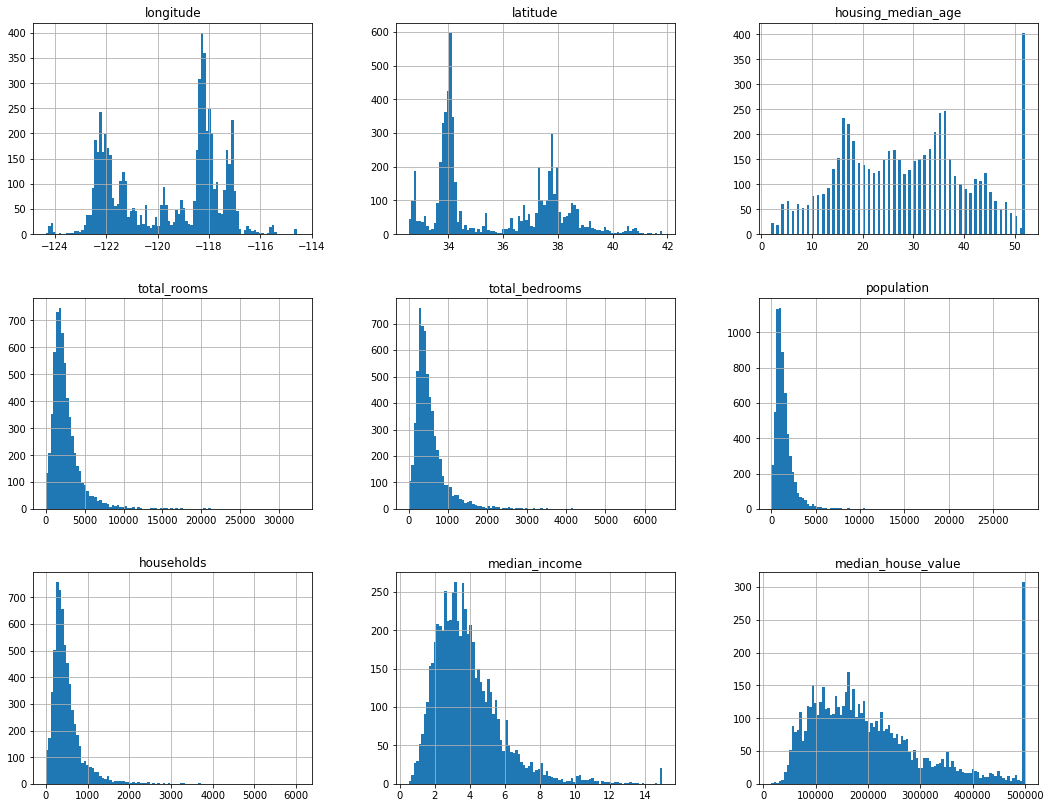

In [8]:
# строим гистограммы с числовыми признаками
df_housing_pd.hist(bins=100, figsize=[18,14]);  

- Данные распределены не равномерно. Присутствуют выбросы. Довольно сильное стандартное отклонение почти во всех столбцах.

- В целевом столбце присутствует внушительный выброс (значение - 50 001).

- Средняя медианная стоимость жилья составляет 206855.816909.

## Подготовка данных

### Ищем и обрабатываем пропуски 

In [9]:
# выведем пропущенные значения 
columns = df_housing.columns
 
for column in columns:
    check_col = F.col(column).isNull()
    print(column, df_housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


- Меняем пропуски на среднее значение столбца.

In [10]:
# меняем пропуски на среднее столбца
df_housing = df_housing.fillna(df_housing.select(F.mean(df_housing['total_bedrooms'])).collect()[0][0])

# проверяем
columns = df_housing.columns
 
for column in columns:
    check_col = F.col(column).isNull()
    print(column, df_housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


### Готовим данные к обучению

In [11]:
# задаем списки колонок с числовыми и категориальными признаками 
categorical_cols = ["ocean_proximity"]
numerical_cols  = ["longitude", "latitude", "housing_median_age", 
                   "total_rooms", "total_bedrooms", "population",
                  "households", "median_income"]
target = "median_house_value" 

#### Формируем выборки

In [12]:
# разделяем датасет на выборки: 75% - обучающая, 25% - тестовая
train_data, test_data = df_housing.randomSplit([.75,.25], seed=RANDOM_SEED)
# проверяем
train_data.count(), test_data.count()

(15406, 5234)

#### Кодируем категориальные признаки обучающего набора

In [13]:
# переводим строковые значения категориального признака в числовые 
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols])

indexerModel = indexer.fit(train_data)

train_data = indexerModel.transform(train_data)

cols = [c for c in train_data.columns for i in categorical_cols if (c.startswith(i))]

# проверяем
train_data.select(cols).show(3) 

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 3 rows



In [14]:
# кодируем категориальные признаки методом OHE
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])

encoderModel = encoder.fit(train_data)

train_data = encoderModel.transform(train_data)

cols = [c for c in train_data.columns for i in categorical_cols if (c.startswith(i))]

# проверяем
train_data.select(cols).show(3) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



In [15]:
# объединяем признаки в один вектор
categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol="categorical_features")

train_data = categorical_assembler.transform(train_data) 

#### Трансформируем числовые признаки обучающего набора

In [16]:
# объединяем числовые признаки в один вектор
numerical_assembler = VectorAssembler(inputCols=numerical_cols,
                                    outputCol="numerical_features")

train_data = numerical_assembler.transform(train_data) 

In [17]:
# масштабируем значения, чтобы сильные выбросы не смещали предсказания модели
standardScaler = StandardScaler(inputCol="numerical_features",
                                outputCol="numerical_features_scaled")

standardScalerModel = standardScaler.fit(train_data)

train_data = standardScalerModel.transform(train_data) 

In [18]:
# подводим итог преобразований 
print(train_data.count())
train_data.columns

15406


['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'ocean_proximity_idx',
 'ocean_proximity_ohe',
 'categorical_features',
 'numerical_features',
 'numerical_features_scaled']

#### Собираем признаки обучающего набора в один вектор 

In [19]:
# задаем названия новых колонок
all_features = ['categorical_features','numerical_features_scaled']

# создаем вектор
final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features")
# создаем колонки
train_data = final_assembler.transform(train_data)

# проверяем 
features = ['categorical_features','numerical_features_scaled','features']

train_data.select(features).show(3)
train_data.count()

+--------------------+-------------------------+--------------------+
|categorical_features|numerical_features_scaled|            features|
+--------------------+-------------------------+--------------------+
|       (4,[2],[1.0])|     [-61.982225379042...|[0.0,0.0,1.0,0.0,...|
|       (4,[2],[1.0])|     [-61.957302891957...|[0.0,0.0,1.0,0.0,...|
|       (4,[2],[1.0])|     [-61.957302891957...|[0.0,0.0,1.0,0.0,...|
+--------------------+-------------------------+--------------------+
only showing top 3 rows



15406

#### Кодируем категориальные признаки тестового набора

In [20]:
# переводим строковые значения категориального признака в числовые 
# кодировщиком, обученным на обучающей выборке
test_data = indexerModel.transform(test_data)

cols = [c for c in test_data.columns for i in categorical_cols if (c.startswith(i))]

# проверяем
test_data.select(cols).show(3) 

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
|     NEAR OCEAN|                2.0|
+---------------+-------------------+
only showing top 3 rows



In [21]:
# кодируем категориальные признаки методом OHE
# кодировщиком, обученным на обучающей выборке
test_data = encoderModel.transform(test_data)

cols = [c for c in test_data.columns for i in categorical_cols if (c.startswith(i))]

# проверяем
test_data.select(cols).show(3) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
|     NEAR OCEAN|                2.0|      (4,[2],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



In [22]:
# объединяем признаки в один вектор
test_data = categorical_assembler.transform(test_data) 

#### Трансформируем числовые признаки тестового набора

In [23]:
# объединяем числовые признаки в один вектор
test_data = numerical_assembler.transform(test_data) 

In [24]:
# масштабируем значения, чтобы сильные выбросы не смещали предсказания модели,
# кодировщиком, обученным на обучающей выборке
test_data = standardScalerModel.transform(test_data) 

In [25]:
# подводим итог преобразований 
print(test_data.count())
test_data.columns

5234


['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'ocean_proximity_idx',
 'ocean_proximity_ohe',
 'categorical_features',
 'numerical_features',
 'numerical_features_scaled']

#### Собираем признаки тестового набора в один вектор 

In [26]:
# создаем колонки
test_data = final_assembler.transform(test_data)

# проверяем 
test_data.select(features).show(3)
test_data.count()

+--------------------+-------------------------+--------------------+
|categorical_features|numerical_features_scaled|            features|
+--------------------+-------------------------+--------------------+
|       (4,[2],[1.0])|     [-61.922411410039...|[0.0,0.0,1.0,0.0,...|
|       (4,[2],[1.0])|     [-61.892504425538...|[0.0,0.0,1.0,0.0,...|
|       (4,[2],[1.0])|     [-61.892504425538...|[0.0,0.0,1.0,0.0,...|
+--------------------+-------------------------+--------------------+
only showing top 3 rows



5234

- Данные обработаны и подготовлены для обучения.

## Обучение моделей

### Строим модель на всех данных

In [27]:
# активируем модель линейной регрессии
lr = LinearRegression(labelCol=target, featuresCol='features', regParam=0.3, 
                      maxIter=10, elasticNetParam=0.8)
# обучаем модель 
model = lr.fit(train_data) 
# получаем предсказание на тестовой выборке
predictions_all = model.transform(test_data)

# сохраняем результат
predicted_all = predictions_all.select("median_house_value", "prediction")
# переименовываем колонку
predicted_all = predicted_all.withColumnRenamed("prediction", "prediction_all") 
# проверяем
predicted_all.show(3)

24/01/10 20:06:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/01/10 20:06:04 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+------------------+------------------+
|median_house_value|    prediction_all|
+------------------+------------------+
|          106700.0|232184.01187392906|
|          128900.0|  223955.056887859|
|          116100.0|249466.86139672948|
+------------------+------------------+
only showing top 3 rows



### Строим модель  на данных без категориальных признаков 

In [28]:
#  создаем модель только с числовыми данными
lr = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled', regParam=0.3, 
                      maxIter=10, elasticNetParam=0.8)
# обучаем модель
model = lr.fit(train_data)

# получаем предсказание на тестовой выборке
predictions_num = model.transform(test_data)

# сохраняем результат
predicted_num = predictions_num.select("median_house_value", "prediction")

# переименовываем колонку
predicted_num = predicted_num.withColumnRenamed("prediction", "prediction_num") 
# проверяем
predicted_num.show(3)

+------------------+------------------+
|median_house_value|    prediction_num|
+------------------+------------------+
|          106700.0| 194426.3572791973|
|          128900.0|175078.95220685517|
|          116100.0|201567.56450190954|
+------------------+------------------+
only showing top 3 rows



### Строим константную модель 

 - Любому объекту модель прогнозирует среднее значение целевого признака. 

In [29]:
# создаем колонку с константным значением 
target_mean = df_housing.select(F.mean(df_housing[target])).collect()[0][0]
train_data = train_data.withColumn("target_mean", F.lit(target_mean).cast('float'))
# проверяем
train_data.select("target_mean").show(5) 

+-----------+
|target_mean|
+-----------+
|  206855.81|
|  206855.81|
|  206855.81|
|  206855.81|
|  206855.81|
+-----------+
only showing top 5 rows



## Анализ результатов

### Вычисление метрик

In [30]:
# считаем среднее значение предсказания первой модели
mean_predict_all = predictions_all.select(F.mean(predictions_all["prediction"])).collect()[0][0]

# считаем среднее значение предсказания второй модели
mean_predict_num = predictions_num.select(F.mean(predictions_num["prediction"])).collect()[0][0]

In [31]:
# оцениваем качество предсказания первой модели
rmse_all = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="prediction", metricName="rmse").evaluate(predictions_all)

mae_all = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="prediction", metricName="mae").evaluate(predictions_all)

r2_all = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="prediction", metricName="r2").evaluate(predictions_all)

print("RMSE первой модели:", rmse_all)
print("MAE первой модели:", mae_all)
print("R2 первой модели:", r2_all)
print("Среднее предсказанное первой модели:", mean_predict_all)
print("Среднее целевое:", target_mean)

RMSE первой модели: 67627.48656166169
MAE первой модели: 49077.17695107703
R2 первой модели: 0.6592013620981447
Среднее предсказанное первой модели: 206206.07816447198
Среднее целевое: 206855.81690891474


In [32]:
# оцениваем качество предсказания второй модели
rmse_num = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="prediction", metricName="rmse").evaluate(predictions_num)

mae_num = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="prediction", metricName="mae").evaluate(predictions_num)

r2_num = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="prediction", metricName="r2").evaluate(predictions_num)

print("RMSE второй модели:", rmse_num)
print("MAE второй модели:", mae_num)
print("R2 второй модели:", r2_num)
print("Среднее предсказанное второй модели:", mean_predict_num)
print("Среднее целевое:", target_mean)

RMSE второй модели: 68399.14237073387
MAE второй модели: 50135.61726556015
R2 второй модели: 0.6513797023074894
Среднее предсказанное второй модели: 206441.70997685756
Среднее целевое: 206855.81690891474


In [33]:
# вычисляем метрики константной модели 
rmse_const = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="target_mean", metricName="rmse").evaluate(train_data)

mae_const = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="target_mean", metricName="mae").evaluate(train_data)

r2_const = RegressionEvaluator(
       labelCol="median_house_value", 
       predictionCol="target_mean", metricName="r2").evaluate(train_data)

print("RMSE константной модели:", rmse_const)
print("MAE константной модели:", mae_const)
print("R2 константной модели:", r2_const)
print("Среднее предсказанное константной модели:", target_mean)
print("Среднее целевое:", target_mean)

RMSE константной модели: 115238.5147354925
MAE константной модели: 91041.95745975594
R2 константной модели: -3.2441105040081908e-06
Среднее предсказанное константной модели: 206855.81690891474
Среднее целевое: 206855.81690891474


In [34]:
# создаем сводную таблицу результатов
data = [('Первая модель', 
         rmse_all, mae_all, r2_all, mean_predict_all, target_mean
        ),
        ('Вторая модель', 
         rmse_num, mae_num, r2_num, mean_predict_num, target_mean
        ),
        ('Константная модель', 
         rmse_const, mae_const, r2_const, target_mean, target_mean
        )
]

columns = ['Model','RMSE','MAE','R2','Mean_predict','Mean_target'] 
df = spark.createDataFrame(data=data, schema=columns).toPandas()

# выводим результат
df

,Model,RMSE,MAE,R2,Mean_predict,Mean_target
0,Первая модель,67627.486562,49077.176951,0.659201,206206.078164,206855.816909
1,Вторая модель,68399.142371,50135.617266,0.651380,206441.709977,206855.816909
2,Константная модель,115238.514735,91041.957460,-0.000003,206855.816909,206855.816909


### Визуализация результатов

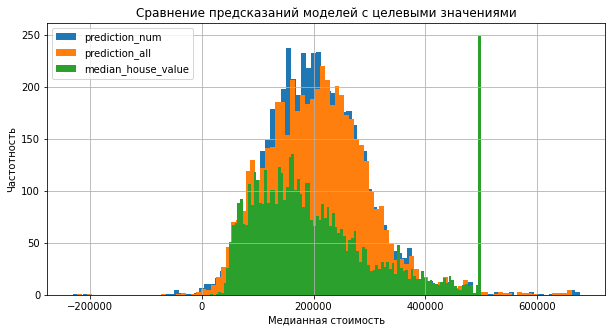

In [35]:
# создаем переменные в пандас
predicted_mhv_all = predicted_all.toPandas() 
predicted_mhv_num = predicted_num.toPandas()

# создаем графики с предсказаниями
predicted_mhv_num["prediction_num"].hist(
    bins=(100),
    figsize =(10,5),
    legend=True    
);

predicted_mhv_all["prediction_all"].hist(
    bins=(100),
    figsize =(10,5),
    legend=True
);

predicted_mhv_all["median_house_value"].hist(
    bins=(100),
    figsize =(10,5),
    legend=True
);

plt.xlabel("Медианная стоимость")
plt.ylabel("Частотность")
plt.title("Сравнение предсказаний моделей с целевыми значениями")

# выводим результат
plt.show()

### Оценка полученных результатов

  - Все модели хорошо обучились. Качество предсказаний у всех моделей выше, чем показатели константной модели.
  
  
  - У второй модели (без категориальных признаков)  результаты оказались хуже.
  
  
  - Наибольшее RSME (67627.486562) - у первой модели, наибольшее R2 (0.659201) также показала  первая модель.
  
  
  - MAE лучшей модели составляем 49077.176951, что довольно неплохо.
  
  
  - На графике видно, что, несмотря на небольшой разброс от среднего, предсказанные моделями значения имеют значительное отклонение от целевых значений. 
  
  
  - Для улучшения результатов требуется более объемная обработка и подготовка признаков, выходящая за рамки этого проекта.   
  
  

## Общий вывод

  - **В ходе работы над проектом**, мы:
  
    - Запустили Spark-сессию;
    
    - Загрузили и изучили данные;
    
    - Провели предобработку (нашли и заменили пропуски);
    
    - Разделили датасет на обучающую и тестовую выборки;
    
    - Обработали категориальные признаки техникой OHE;
    
    - Провели масштабирование числовых признаков;
    
    - Построили две модели LinearRegression с разными исходными признаками (с категориальными и без категориальных признаков);
    
    - Сравнили результаты работы моделей по метрикам RMSE, MAE и R2;
    
    - Сравнили результаты работы моделей с константной моделью, предсказывающей любому объекту среднее значение целевого признака;
    
    - Визуализировали предсказания моделей;
    
    - Оформили промежуточные и общий выводы.  
    
    
  - **Резюме:**
  
    - **Лучшая модель** показала такие результаты: **RMSE - 67627.486562, MAE - 49077.176951, R2 - 0.659201**.
     

In [36]:
# выходим из Spark-сесии 
spark.stop()